# Train

In [1]:
import os
from box import Box
import torch.optim as optim

from utils import random_seed, sparse2Tensor
from dataset import VAEData
from trainer import Trainer
from model import VAE

##############################ARGS##################################
args = {
    ######data#######
    'min_user_cnt' : 5,
    'min_movie_cnt' : 0,
    'n_heldout' : 3000,
    'target_prop' : 0.2,
    'min_movie_to_split' : 5,
    
    #####model######
    'hidden_dim' : 600,
    'latent_dim' : 200,
    'stnd_mixture_weight' : 3/20,
    'post_mixture_weight' : 3/4,
    'unif_mixture_weight' : 1/10,
    'dropout_ratio' : 0.5,
    
    #####optimizer####
    'lr' : 1e-4,
    'wd' : 0.00,
    
    ######trainer#####
    'batch_size' : 256,
    'epochs' : 100,
    'en_epochs' : 3,
    'de_epochs' : 1,
    'beta' : None,
    'gamma' : 0.005,
    'not_alter' : False,
    'ndcg_k' : 50,
    'recall_k' : 20,
    'verbose' : True,
    
    #####etc#######
    'base_dir' : '/opt/ml/input/data/',
    'random_seed' : 42,
    'device' : 'cuda'
}
args = Box(args)
##############################ARGS##################################

##############################PATHS##################################
dir_data = os.path.join(args.base_dir, 'train')
path_rating = os.path.join(dir_data, 'train_ratings.csv')
dir_output = os.path.join(os.getcwd(), 'output')
dir_preprocessing = os.path.join(os.getcwd(), 'data')

dir_file_path = {
    'dir_base': args.base_dir,
    'dir_data': dir_data,
    'rating': path_rating,
    'dir_output': dir_output,
    'dir_preprocessing' : dir_preprocessing
}
dir = Box(dir_file_path)
##############################PATHS##################################
    
random_seed(args.random_seed)

In [2]:
data_kwargs = {
    'data_dir' : dir.rating,
    'dir_preprocessing' : dir.dir_preprocessing,

    'min_user_cnt' : args.min_user_cnt,
    'min_movie_cnt' : args.min_movie_cnt,

    'n_heldout' : args.n_heldout,
    'target_prop' : args.target_prop,
    'min_movie_to_split' : args.min_movie_to_split
}

data = VAEData(**data_kwargs)

filter min...
user split...
getting data...
input target split...
input target split...
encoding...
encoding...
encoding...
encoding...
encoding...
encoding...
complete!


In [3]:
datasets = data.datasets # dict, {train_data, valid_data(input, target), test_data(input, target), inference_data}
input_dim = data.n_movies

model_kwargs = {
    'hidden_dim' : args.hidden_dim,
    'latent_dim' : args.latent_dim,
    'input_dim' : input_dim,

    'mixture_weights' : [args.stnd_mixture_weight,
                         args.post_mixture_weight,
                         args.unif_mixture_weight],
}

model = VAE(**model_kwargs).to(args.device)
model_best = VAE(**model_kwargs).to(args.device)

decoder_param = set(model.decoder.parameters())
encoder_param = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_param, lr=args.lr, weight_decay=args.wd)
optimizer_decoder = optim.Adam(decoder_param, lr=args.lr, weight_decay=args.wd)

trainer_kwargs = {
    #model & optimizer
    'model' : model,
    'model_best' : model_best,
    'optimizer_encoder' : optimizer_encoder,
    'optimizer_decoder' : optimizer_decoder,

    #hyperparameters
    'batch_size' : args.batch_size,
    'epochs' : args.epochs,
    'en_epochs' : args.en_epochs,
    'de_epochs' : args.de_epochs,
    'beta' : args.beta,
    'gamma' : args.gamma,
    'dropout_ratio' : args.dropout_ratio,
    'not_alter' : args.not_alter,
    'ndcg_k' : args.ndcg_k,
    'recall_k' : args.recall_k,


    #datasets 
    'datasets' : datasets, 

    #etc
    'output_path' : dir.dir_output,
    'model_name' : 'RecVAE',
    'device' : args.device,
    'verbose' : args.verbose,

    # label encoder
    'user_encoder' : data.user_encoder,
    'item_encoder' : data.item_encoder
}

trainer = Trainer(**trainer_kwargs) 

In [4]:
trainer.run()

[epoch 0/100 || valid_ndcg@50 : 0.1508 | best valid_ndcg : 0.1508 | train ndcg@50 : 0.3735
[epoch 1/100 || valid_ndcg@50 : 0.2736 | best valid_ndcg : 0.2736 | train ndcg@50 : 0.5443
[epoch 2/100 || valid_ndcg@50 : 0.3085 | best valid_ndcg : 0.3085 | train ndcg@50 : 0.6055
[epoch 3/100 || valid_ndcg@50 : 0.3328 | best valid_ndcg : 0.3328 | train ndcg@50 : 0.6401
[epoch 4/100 || valid_ndcg@50 : 0.3460 | best valid_ndcg : 0.3460 | train ndcg@50 : 0.6579
[epoch 5/100 || valid_ndcg@50 : 0.3551 | best valid_ndcg : 0.3551 | train ndcg@50 : 0.6699
[epoch 6/100 || valid_ndcg@50 : 0.3599 | best valid_ndcg : 0.3599 | train ndcg@50 : 0.6794
[epoch 7/100 || valid_ndcg@50 : 0.3642 | best valid_ndcg : 0.3642 | train ndcg@50 : 0.6888
[epoch 8/100 || valid_ndcg@50 : 0.3681 | best valid_ndcg : 0.3681 | train ndcg@50 : 0.6922
[epoch 9/100 || valid_ndcg@50 : 0.3713 | best valid_ndcg : 0.3713 | train ndcg@50 : 0.6965
[epoch 10/100 || valid_ndcg@50 : 0.3746 | best valid_ndcg : 0.3746 | train ndcg@50 : 0.701

In [5]:
trainer.test()

ndcg@50:	0.0806
recall@20:	0.0648


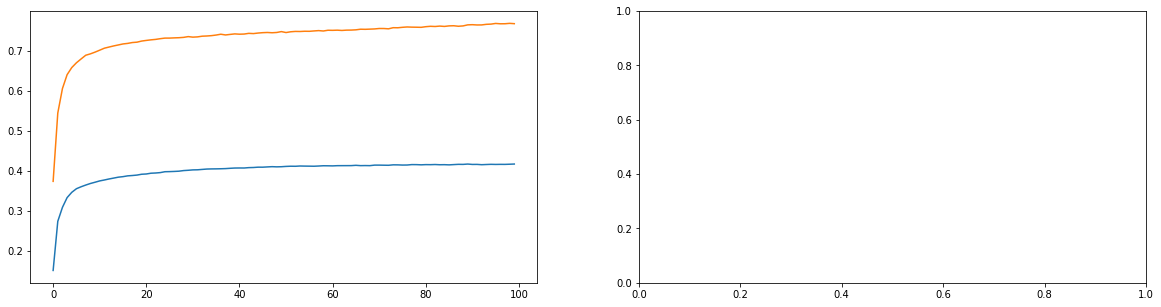

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1,2,figsize=(20,5))
sns.lineplot(x = range(len(trainer.eval_ndcg_list)),
             y = trainer.eval_ndcg_list,
             ax = axes[0])
sns.lineplot(x = range(len(trainer.train_ndcg_list)),
             y = trainer.train_ndcg_list,
             ax = axes[0])
plt.show()

# Inference

In [20]:
import torch
import numpy as np

In [32]:
trainer.model_best

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=6807, out_features=600, bias=True)
    (ln1): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc2): Linear(in_features=600, out_features=600, bias=True)
    (ln2): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc3): Linear(in_features=600, out_features=600, bias=True)
    (ln3): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc4): Linear(in_features=600, out_features=600, bias=True)
    (ln4): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc5): Linear(in_features=600, out_features=600, bias=True)
    (ln5): LayerNorm((600,), eps=0.1, elementwise_affine=True)
    (fc_mu): Linear(in_features=600, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=600, out_features=200, bias=True)
  )
  (prior): CompositePrior(
    (encoder_old): Encoder(
      (fc1): Linear(in_features=6807, out_features=600, bias=True)
      (ln1): LayerNorm((600,), eps=0.1, elementwise_affine=True)
      (fc2

In [48]:
import pandas as pd
def inference(trainer, data, k, metric):
    
    best_model = trainer.model_best
    input_data = sparse2Tensor(None, trainer.inference_data).to(trainer.device)
    users = range(data.n_users)
    model.eval()
    
    with torch.no_grad():
        prediction = model(input_data, calculate_loss=False)
        print(prediction)
        prediction[torch.nonzero(input_data, as_tuple=True)] = -np.inf
        scores, movies = torch.topk(prediction, dim=1, k=k)
        
        users = np.tile(users, (k,1)).T
        user_list = np.concatenate([user for user in users])
        score_list = torch.cat([score for score in scores])
        movie_list = torch.cat([movie for movie in movies])
    
    user_decoder = {value : key for (key, value) in trainer.user_encoder.items()}
    item_decoder = {value : key for (key, value) in trainer.item_encoder.items()}
    
    inference_df = pd.DataFrame()
    inference_df['user'] = user_list
    inference_df['item'] = movie_list.cpu().numpy()
    inference_df['score'] = score_list.cpu().numpy()
    
    inference_df['user'] = inference_df['user'].apply(lambda x : user_decoder[x])
    inference_df['item'] = inference_df['item'].apply(lambda x : item_decoder[x])

    return inference_df

In [49]:
inference_df = inference(trainer, data, k=10, metric='ndcg')
inference_df = inference_df.sort_values(['user', 'score'], ascending=[True, False])

tensor([[ -0.2521,  -0.5102,   0.3210,  ...,  -3.7108,  -0.7989,  -0.6747],
        [  1.3223,  -0.6010,   0.7618,  ...,  -2.4126,  -4.0915,  -3.6356],
        [  2.3648,   3.2395,  -0.3167,  ...,  -5.9575,  -8.3109,  -7.4931],
        ...,
        [  0.3910,   0.8479,  -0.4543,  ...,  -6.3997,  -5.5074,  -5.3943],
        [ -1.0859,   0.5582,  -0.9841,  ...,  -8.5443, -10.1208,  -8.1709],
        [  2.4803,   0.1983,   0.4127,  ...,  -2.4840,  -5.0138,  -5.8199]],
       device='cuda:0')


In [52]:
inference_df

,user,item,score
132660,11,4370,4.274961
132661,11,37386,3.410874
132662,11,4886,3.311004
132663,11,7373,3.298671
132664,11,2,3.235821
...,...,...,...
49275,138493,2011,2.913460
49276,138493,593,2.912793
49277,138493,7147,2.904695
49278,138493,53125,2.864029


In [53]:
SUB_PATH = '/opt/ml/input/code/_main/seunghwan/result/'
inference_df.drop('score', axis=1, inplace=True)
i = 1
while True :
    if os.path.exists(os.path.join(SUB_PATH, f'RecVAE_{i}.csv')) :
        i += 1
        continue
    inference_df.to_csv(os.path.join(SUB_PATH, f'RecVAE_{i}.csv'), index=False)
    break